# #Olá mundo

In [1]:
# Importando as bibliotecas que serão usadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn

### Algumas configurações

In [2]:
# Aumentando a quantidade de colunas exibidas pelo Pandas
pd.set_option('display.max_rows', 20)

# Removendo alguns avisos
import warnings
warnings.filterwarnings('ignore')

### Importando, agrupando e ajustando algumas coisas nos datasets

In [3]:
# Selecionando colunas de interesse nos datasets
colunas_hei = ['SEQN', 'ADHERENCE', 'HEI2015_TOTAL_SCORE']

# Importando os dados
df_demo = pd.read_csv('./data/DEMO_PHQ.csv', sep =',', encoding='UTF-8',)
df_hei = pd.read_csv('./data/PAG_HEI.csv',sep =',',usecols=colunas_hei, encoding='UTF-8')

# Renomeando coluna df_hei
df_hei.rename(columns={'HEI2015_TOTAL_SCORE': "ESCORE_ALIMENTACAO"}, inplace=True)

# Combinando os dataframes utilizando a coluna SEQN
df_merge = pd.merge(df_demo, df_hei, on='SEQN')

# Removendo a coluna SEQN
df_merge.drop(columns='SEQN',axis=1,inplace=True)

# Eliminando valores nulos do dataframe combinado
df_merge = df_merge.dropna(axis=0)

In [4]:
# Criando lista com os índices do questionário DPQ
dpq_cols = []
for i in range(10,91,10):
    dpq_cols.append("DPQ0{}".format(i))   


### Identificando e tratando variaveis imprecisas como "NAO SABE" ou "SE RECUSOU A RESPONDER"

#### No questionário

In [5]:
# Contando quantas respostas 7 e 9 há no questionário
sete_nove = {}
for col in dpq_cols:
    sete = len(df_merge[df_merge[col] == 7])
    nove = len(df_merge[df_merge[col] == 9]) 
    sete_nove[col] = [sete, nove]

sete_nove

{'DPQ010': [0, 8],
 'DPQ020': [0, 5],
 'DPQ030': [0, 6],
 'DPQ040': [0, 5],
 'DPQ050': [0, 3],
 'DPQ060': [0, 4],
 'DPQ070': [0, 2],
 'DPQ080': [0, 9],
 'DPQ090': [0, 2]}

In [6]:
# Primeiramente, peço perdão pela gambiarra
# Segundamente, aqui eu removo linhas que possuem mais de uma resposta 9
# Terceiramente, quando eu dropei as colunas usando o índice da coluna,
# o programa alterou o tamanho do dataframe e acusou uma exceção de tamanho 
# de índice, então eu forcei a passagem.
try:
    for linha in df_merge.index:
        count = 0
        for coluna in range(9):
            if df_merge[dpq_cols].iloc[linha,coluna] == 9:
                count +=1
        if count >= 2:
            df_merge.drop(df_merge.iloc[linha].name, inplace=True)
except Exception:
    pass

In [7]:
# Substituindo respostas 7 e 9 no questionário por 0, para ignorar na contagem
for coluna in dpq_cols:
    df_merge[coluna] = df_merge[coluna].replace([7,9], 0)

In [8]:
# Somando valores do DPQ para classificação dos escores
df_merge['ESCORE_DPQ'] = df_merge[dpq_cols].sum(axis=1)

# Aplicando binning aos escores DPQ
# 0: sem sintomas; 
# 1: sintomas leves
# 2: sintomas moderados
# 3: sintomas moderadamente severos
# 4: sintomas severos
df_merge['CLASS_DPQ'] = pd.cut(df_merge.ESCORE_DPQ, bins=[0,5,10,15,20,27], labels=[0,1,2,3,4], include_lowest=True)

#### Escolaridade

In [9]:
df_merge.DMDEDUC[df_merge.DMDEDUC >= 7].value_counts()

9    1
Name: DMDEDUC, dtype: int64

In [10]:
# Removendo linha com escolaridade imprecisa
df_merge.drop(df_merge[df_merge.DMDEDUC >= 7].index, inplace=True)

#### Renda

In [229]:
# Analisando os valores da variável Renda
df_merge.INDFMINC.value_counts(normalize=True).sort_index()

1.0     0.036906
2.0     0.055028
3.0     0.085083
4.0     0.078895
5.0     0.080884
6.0     0.133923
7.0     0.103204
8.0     0.096354
9.0     0.059227
10.0    0.055470
11.0    0.215028
Name: INDFMINC, dtype: float64

Text(0.5, 6.799999999999997, 'Renda')

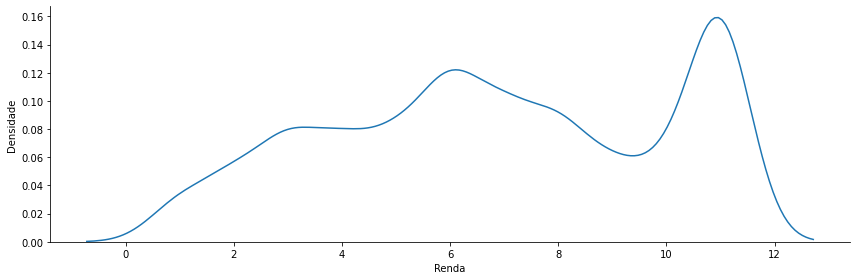

In [228]:
# Gráfico de densidade da variável Renda
sbn.displot(
    df_merge.INDFMINC,
    height=4,
    aspect=3,
    kind='kde'
)
plt.ylabel('Densidade')
plt.xlabel('Renda')

Achei melhor remover todos os valores imprecisos de renda

In [13]:
# Removendo linhas com renda imprecisa
df_merge.drop(df_merge[df_merge.INDFMINC >= 12].index, inplace=True)

df_merge.INDFMINC.value_counts(normalize=False).sort_index()

1.0     167
2.0     249
3.0     385
4.0     357
5.0     366
6.0     606
7.0     467
8.0     436
9.0     268
10.0    251
11.0    973
Name: INDFMINC, dtype: int64

### Analisando sintomas de depressão e variáveis demográficas

#### Sexo

<AxesSubplot:>

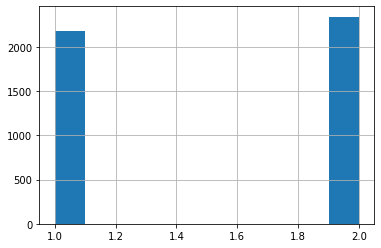

In [130]:
df_merge.RIAGENDR.hist()

<AxesSubplot:xlabel='RIAGENDR', ylabel='ESCORE_DPQ'>

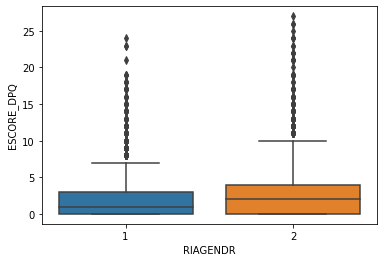

In [225]:
sbn.boxplot(
    x=df_merge.RIAGENDR,
    y=df_merge.ESCORE_DPQ,
    orient='v'
)

<AxesSubplot:xlabel='RIDAGEYR', ylabel='ESCORE_DPQ'>

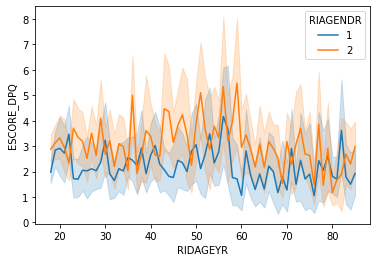

In [154]:
sbn.lineplot(
    x=df_merge.RIDAGEYR,
    y=df_merge.ESCORE_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')

Note que em paticamente todas as idades, as pessoas do sexo feminino tiveram pontuações maiores do que as do sexo masculino.

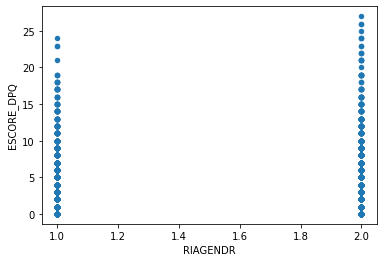

In [156]:
df_merge.plot(
    x='RIAGENDR',
    y='ESCORE_DPQ',
    kind='scatter'
)

plt.show()

In [165]:
print('Masculino\n',df_merge.ESCORE_DPQ[df_merge.RIAGENDR == 1].describe())
print()
print('Feminino\n',df_merge.ESCORE_DPQ[df_merge.RIAGENDR == 2].describe())

Masculino
 count    2180.000000
mean        2.267431
std         3.409829
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        24.000000
Name: ESCORE_DPQ, dtype: float64

Feminino
 count    2345.000000
mean        3.136461
std         3.965634
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        27.000000
Name: ESCORE_DPQ, dtype: float64


Note também que pessoas do sexo feminino parecem possuir pontuações mais altas.

Testaremos melhor mais para frente

#### Idade

<AxesSubplot:xlabel='RIDAGEYR', ylabel='ESCORE_DPQ'>

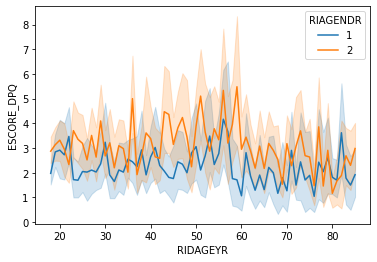

In [166]:
sbn.lineplot(
    x=df_merge.RIDAGEYR,
    y=df_merge.ESCORE_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')

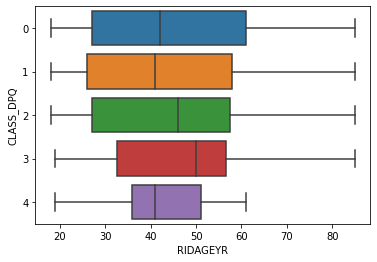

In [169]:
sbn.boxplot(
    data=df_merge,
    x='RIDAGEYR',
    y='CLASS_DPQ',
    orient='h'
)
plt.show()

Aparentemente, pessoas com idades entre 40 e 60 anos são as que mais pontuaram no questionáio DPQ

In [189]:
# Agrupando idades para comparar com as classificações do questionário DPQ

df_merge['AGE_CUT'] = pd.cut(df_merge.RIDAGEYR, bins=[18,20,30,40,50,60,70,80,84], labels=['18-19','20-29','30-39','40-49','50-59','60-69','70-79','80-84'], include_lowest=True)

In [193]:
df_merge.AGE_CUT.value_counts().sort_index()

18-19    555
20-29    864
30-39    716
40-49    690
50-59    548
60-69    561
70-79    374
80-84    126
Name: AGE_CUT, dtype: int64

<AxesSubplot:xlabel='AGE_CUT', ylabel='CLASS_DPQ'>

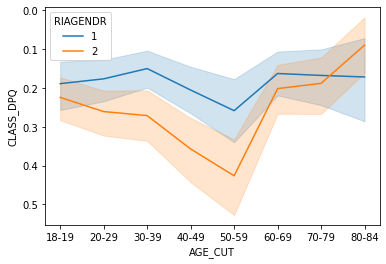

In [204]:
# Cassifixações DPQ X Faixas de idade
sbn.lineplot(
    x=df_merge.AGE_CUT,
    y=df_merge.CLASS_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')

Analisando o gráfico acima, podemos definir a faixa etária entre 50-59 anos para ambos os sexos.

#### Etnia

In [ ]:
sbn.boxplot(
    data=df_merge,
    x='DMDEDUC',
    y='ESCORE_DPQ',
    orient='v'
)
plt.show()

<AxesSubplot:xlabel='RIDRETH1', ylabel='ESCORE_DPQ'>

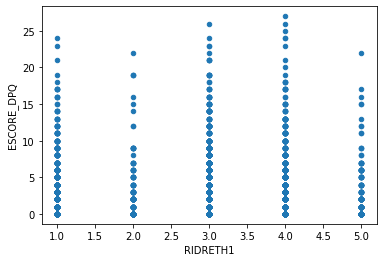

In [142]:
df_merge.plot(
    x='RIDRETH1',
    y='ESCORE_DPQ',
    kind='scatter'
)

<AxesSubplot:xlabel='AGE_CUT', ylabel='CLASS_DPQ'>

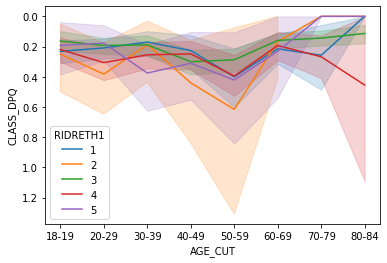

In [201]:
sbn.lineplot(
    x=df_merge.AGE_CUT,
    y=df_merge.CLASS_DPQ,
    hue=df_merge.RIDRETH1,
    palette='tab10')

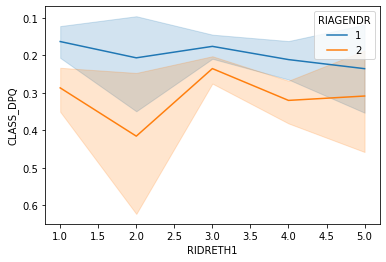

In [216]:
# Sexo Masculino
sbn.lineplot(
    x=df_merge.RIDRETH1,
    y=df_merge.CLASS_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')
plt.show()

O sexo feminino aponta para 'negro não-hispânico'.

Já o sexo masculino, aponta para 'negro não-hispânico' e 'outro hispânico'.

#### Escolaridade

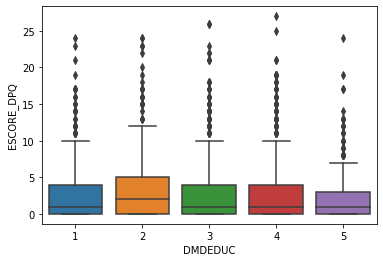

In [103]:
# Escolaridade
sbn.boxplot(
    data=df_merge,
    x='DMDEDUC',
    y='ESCORE_DPQ',
    orient='v'
)
plt.show()

<AxesSubplot:xlabel='DMDEDUC', ylabel='ESCORE_DPQ'>

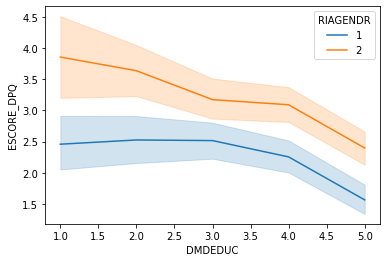

In [226]:
sbn.lineplot(
    x=df_merge.DMDEDUC,
    y=df_merge.ESCORE_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')

O gráfico nos mostra que quanto menor o grau de escolaridade, maior a pontuação no questionário DPQ.

O gráfico também nos mostra que homens e mulheres para um mesmo grau de escolaridade, possuem pontuações diferentes no questionário DPQ

#### Renda

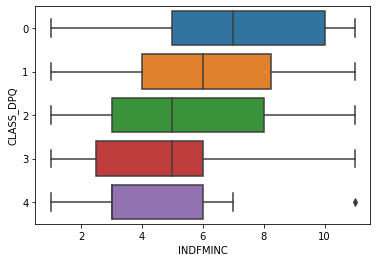

In [28]:
# Renda
sbn.boxplot(
    data=df_merge,
    x='INDFMINC',
    y='CLASS_DPQ',
    orient='h'
)
plt.show()

<AxesSubplot:xlabel='INDFMINC', ylabel='CLASS_DPQ'>

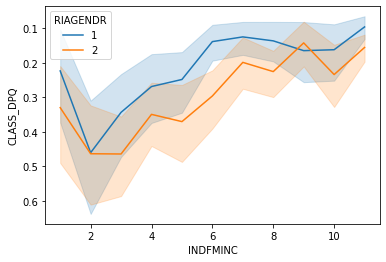

In [227]:
sbn.lineplot(
    x=df_merge.INDFMINC,
    y=df_merge.CLASS_DPQ,
    hue=df_merge.RIAGENDR,
    palette='tab10')

Ambos os sexos convergem para renda entre 5000-9999 dólares

#### Conclusão

Com base na análise bivariada entre variáveis demográficas e o resultado do questionário DPQ. Foi possível elaborar um perfil com maior incidência de sintomas de depressão: (i) sexo feminino, (ii) entre 50 e 59 anos, (iii) negra não-hispânica, (iv) que estudou até o 12° ano e (v) que possui renda entre 5000 e 9999 dólares.

### Analisando hábitos saudáveis e características demográficas

# Alimentação

<AxesSubplot:xlabel='ESCORE_ALIMENTACAO', ylabel='CLASS_DPQ'>

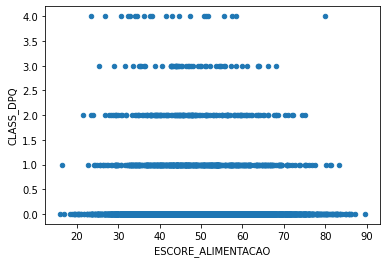

In [72]:
df_merge.plot(
    x='ESCORE_ALIMENTACAO',
    y='CLASS_DPQ',
    kind='scatter'
)

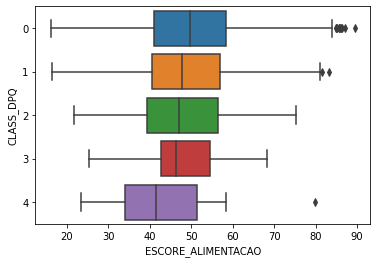

In [50]:
# Escore Alimentação
sbn.boxplot(
    data=df_merge,
    x='ESCORE_ALIMENTACAO', 
    y='CLASS_DPQ',
    orient='h'
)
plt.show()

# Atividade Fisica

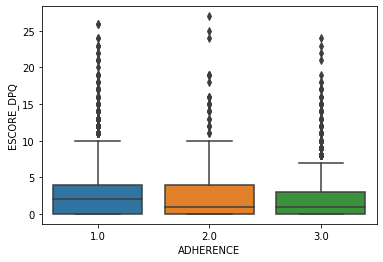

In [75]:
# Atividade física
sbn.boxplot(
    data=df_merge,
    x='ADHERENCE',
    y='ESCORE_DPQ',
    orient='v'
)
plt.show()

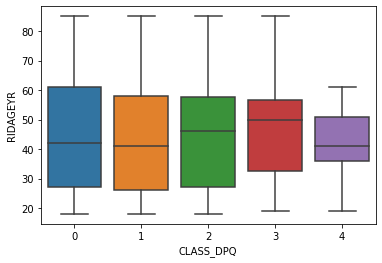

In [34]:
sbn.boxplot(
    data=df_merge,
    y='RIDAGEYR',
    x='CLASS_DPQ',
    orient='v'
)
plt.show()

# Final


In [56]:
df_merge.columns

Index(['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070',
       'DPQ080', 'DPQ090', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC',
       'INDFMINC', 'ADHERENCE', 'ESCORE_ALIMENTACAO', 'ESCORE_DPQ',
       'CLASS_DPQ'],
      dtype='object')

In [69]:
df_final = df_merge[['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC','INDFMINC', 'ADHERENCE', 'ESCORE_ALIMENTACAO', 'ESCORE_DPQ']]

In [70]:
df_final.corr

<bound method DataFrame.corr of       RIAGENDR  RIDAGEYR  RIDRETH1  DMDEDUC  INDFMINC  ADHERENCE  \
1            2        44         4        4      11.0        2.0   
2            1        70         3        5      11.0        3.0   
4            2        18         2        3      11.0        3.0   
5            1        19         3        4      11.0        3.0   
6            1        21         2        3       3.0        3.0   
...        ...       ...       ...      ...       ...        ...   
5329         2        58         5        2       3.0        1.0   
5330         2        66         1        1       8.0        2.0   
5331         1        19         4        4       2.0        2.0   
5332         1        34         3        4       7.0        1.0   
5333         1        21         1        2       6.0        3.0   

      ESCORE_ALIMENTACAO  ESCORE_DPQ  
1              35.553899         0.0  
2              63.551696         0.0  
4              47.074393         4

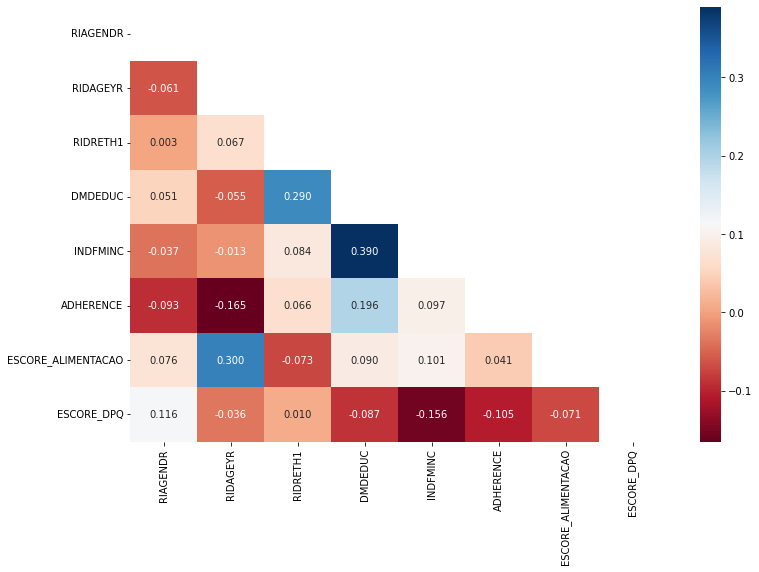

In [71]:
sbn.set_context(font_scale=1.9)
plt.figure(figsize=(12,8))

sbn.heatmap(
    df_final.corr(), 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    mask=np.triu(np.ones_like(df_final.corr()))
)

plt.show()

In [35]:
#df_merge.CLASS_DPQ[df_merge.CLASS_DPQ.isnull() == False].value_counts()

In [36]:

# # Renomeando colunas
# df_final.rename(columns={  
#     'RIAGENDR':'sexo', 
#     'RIDAGEYR':'idade',
#     'RIDRETH1':'cor',
#     'INDFMINC':'renda',
#     'DMDEDUC':'educacao', 
#     'ADHERENCE':'esc_at_fisica',
#     'ESCORE_ALIMENTACAO':'esc_alimentacao'
# })